In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import *
from torch.utils.data import Dataset, DataLoader
#import transforms
from torchvision import transforms
from Data.IngredientsLoader import IngredientsDataset
import matplotlib.pyplot as plt
import time
import copy
import os

#choose random seed
seed = 42
np.random.seed(seed)

#depends on our vector of ingredients
num_classes = 3

In [2]:
#hyperparameters
batch_size = 4
learning_rate = 1e-3
momentum=0.9
transforms = transforms.Compose(
[
    transforms.ToTensor(),
    transforms.Resize((224,224))
    #add normilization
])
#criterion of loss for multilabel classification
criterion = nn.BCEWithLogitsLoss()
use_cuda = False

In [ ]:
#load first time the dataset
# train_dataset = torchvision.datasets.Food101(dataset_path, split='train', download=True, transform=transforms)
# test_dataset = torchvision.datasets.Food101(dataset_path, split='test', download=True, transform=transforms)

In [3]:
# load the dataset

dataset_path = 'food101/train/food-101/images'
json_path = dataset_path + '/ing_jsn.json'

dataset = IngredientsDataset(json_path, dataset_path, transforms)

# split train and test
train_size = int(0.8 * dataset.__len__())
test_size = dataset.__len__() - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)  # not working well
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [4]:
def imshow(inp, title=None):
	"""
    Show tensor image with matplotlib
    :param inp: image tensor
    :param title: title of the image
    :return:
    """
	inp = inp.cpu() # if device else inp
	inp = inp.numpy().transpose((1, 2, 0))

	# mean = np.array([0.485, 0.456, 0.406])
	# std = np.array([0.229, 0.224, 0.225])
	# inp = std * inp + mean
	# inp = np.clip(inp, 0, 1)

	plt.imshow(inp)
	if title is not None:
		plt.title(title)
	# plt.pause(0.001)

In [5]:
images, ing_list = next(iter(train_dataloader))

In [ ]:
#see an example of the dataset
batch_example = next(iter(train_dataloader))
imshow(batch_example['image'][0,:,:,:], title='first image')

In [16]:
#model
net = models.resnet18(pretrained=True)
#net = net.cuda() if device =='cuda:0'  else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
#edit the final layer of the model
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, num_classes)
net = net.cuda() if device =='cuda:0'  else net
net #check the model after the change

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [54]:
#evaluation of model on test set
def evaluate_model(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    return epoch_loss, epoch_acc

evaluate_model(net, test_dataloader, criterion)

FileNotFoundError: [Errno 2] No such file or directory: './food101/test/food-101/images/lasagna\\2846781.jpg'

In [ ]:
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 128)
net.fc = net.fc.cuda() if use_cuda else net.fc

In [ ]:
n_epochs = 5
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()

        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if batch_idx % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in test_dataloader:
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')


        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'resnet.pt')
            print('Improvement-Detected, save-model')
    net.train()

In [ ]:
#plot statistics
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

AttributeError: 'Subset' object has no attribute 'classes'

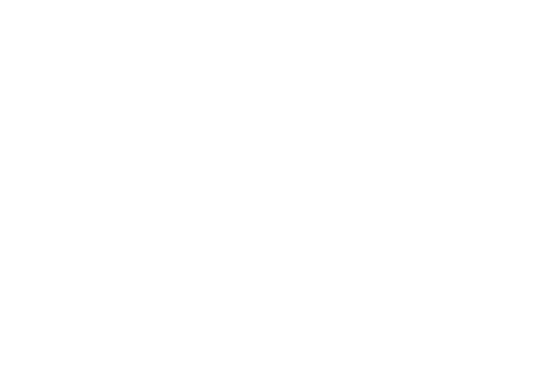

In [18]:
#visualize the model
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))

    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if use_cuda:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if use_cuda else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])

            if images_so_far == num_images:
                return

plt.ion()
visualize_model(net)
plt.ioff()